In [ ]:
import cProfile
import warnings
import numpy as np
from math import ceil
from typing import Any, Callable, Dict, List
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.svm import LinearSVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from xgboost import XGBClassifier


# silencing deprecation warnings coming from pandas
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Load the data
df = pd.read_csv('./data.csv')

In [ ]:
# Display all column names
col_names = [df.columns[i:i+8] for i in range(0, len(df.columns), 8)]
print(tabulate(col_names))

In [ ]:
# Basic description of the dataset
divider = '-' * 120
num_rows, num_cols = df.shape

pd.set_option('display.max_columns', None)

print(f'{divider}\n\nNumber of rows: {num_rows}')
print(f'Number of columns: {num_cols}\n')
print(f'{divider}\n\nDescription:\n{df.describe()}\n')
print(f'{divider}\n\nHead:\n{df.head()}\n')

In [ ]:
# Frequency Distribution of the Response column
response_frequency = df['Response'].value_counts()
plt.figure(figsize=(5,4))
response_frequency.sort_index().plot(kind='bar', colormap='summer')
plt.title('Frequency of Response Category')
plt.xlabel('Response')
plt.ylabel('Frequency')
plt.grid(axis='y')

In [ ]:
# Frequency of different data types in the dataset
data_types = df.dtypes.value_counts()
data_types.index = data_types.index.astype(str)

plt.figure(figsize=(5,4))
bars = plt.bar(data_types.index, data_types)

for bar in bars:
    y = bar.get_height()
    plt.text(x=bar.get_x() + bar.get_width()/2, y=y+5, s=y, ha='center')

plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Data Types Count')
plt.grid(axis='y')

In [ ]:
# Show the correlation between bio metrics and response with a heatmap
biometrics_correlation = df[['Ins_Age', 'Ht', 'Wt', 'BMI', 'Response']].corr()

plt.figure(figsize=(5,4))
sns.heatmap(biometrics_correlation, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Bio Metrics and Response Correlation Heat Map')
plt.show()

In [ ]:
# The 20 most highly correlated columns plotted on a heatmap
df['Product_Info_2'] = pd.factorize(df['Product_Info_2'])[0]
correlations_df = df.drop('Id', axis=1).corr()

average_correlation_df = correlations_df.abs().mean().sort_values(ascending=False)
highest_corr_cols = average_correlation_df.head(20).index
top_correlations_df = correlations_df.loc[highest_corr_cols, highest_corr_cols]

plt.figure(figsize=(15, 10))
sns.heatmap(top_correlations_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Most highly correlated columns')

In [ ]:
# Show the correlation of the most influential columns on Response
response_correlations = df.corr()['Response'].sort_values(ascending=False)
top_correlations = pd.concat([response_correlations.head(11), response_correlations.tail(10)])

plt.figure(figsize=(15, 10))
top_correlations.drop('Response').plot(kind='bar')
plt.title('Columns correlated with Response')
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.grid(axis='y')
plt.show()

In [ ]:
def plot(dataframe: DataFrame, payload: Dict[str, List[List[str]]], num_cols: int=2) -> None:
    """
    Create a series of plots for specified columns against Response

    Args:
        dataframe: DataFrame
            A pandas dataframe containing the dataset

        plots: Dict[str, List[List[str]]]
            A dictionary containing a mapping of plot_type to 2D list of columns to be plotted

        num_cols: int
            Number of columns to be displayed in the final figure

    Returns:
        None

    Raises:
        ValueError
            When an invalid plot_type is provided
    """
    title_number = 1

    for plot in payload.keys():
        
        for target_columns in payload[plot]:
            num_target_cols = len(target_columns)
            num_cols = num_target_cols if num_target_cols < num_cols else num_cols
            num_rows = ceil(num_target_cols/num_cols)
            fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))
            axes = axes.ravel()
            plt.suptitle('Figure_' + str(title_number), fontsize=16)
            title_number += 1

            if leftover_plots := len(axes) - num_target_cols:
                for i in range(1, leftover_plots+1):
                    fig.delaxes(axes[-i])

            for i, col in enumerate(target_columns):
                if plot == 'violin':
                    sns.violinplot(data=dataframe, x=col, y="Response", ax=axes[i], palette='viridis')

                elif plot == 'kde':
                    sns.kdeplot(data=dataframe, x=col, ax=axes[i], hue='Response', fill=True, alpha=0.05, palette='viridis')

                elif plot == 'histogram':
                    sns.histplot(data=dataframe, x=col, kde=True, ax=axes[i])

                elif plot == 'countplot':
                    sns.countplot(data=dataframe, x=col, palette='viridis', ax=axes[i])

                else:
                    raise ValueError(f'Plot type \'{plot}\' is not supported')

In [ ]:
payload = {
    'kde': [
        ['Ins_Age', 'Ht', 'Wt', 'BMI'],
        ['Product_Info_3', 'Product_Info_4'],
        list(df.filter(regex=f'^Insurance_History_\d+$').columns),
        list(df.filter(regex=f'^Family_Hist_\d+$').columns)
    ],
    'violin': [
        ['Product_Info_1','Product_Info_5','Product_Info_6','Product_Info_7']
    ],
    'histogram': [
        ['Ins_Age', 'Ht', 'Wt', 'BMI']
    ],
    'countplot': [
        list(df.filter(regex=f'^InsuredInfo_\d+$').columns)
    ]
}

# plot(df, payload)

In [ ]:
def missing_values(dataframe: DataFrame, plot: bool=True) -> None:
    """
    Calculate and plot the number and percentage of missing values per column

    Args:
        dataframe: DataFrame
            A pandas DataFrame

        plot: bool
            Default: True
            Set to False if you do not want to
            plot sum and percentage of missing values

    Returns:
        DataFrame:
            A dataframe containing the number and
            percantage of missing values per column
    """
    # Find missing values. Sum the result and calculate percentages
    cols_with_missing_values = [col for col in dataframe.columns if dataframe[col].isna().any()]
    missing_vals = dataframe[cols_with_missing_values].isna().sum().sort_values()
    missing_percentages = round(missing_vals / len(dataframe) * 100, 2)
    missing_vals_df = pd.DataFrame({'Num_Missing': missing_vals, 'Percentages': missing_percentages})

    if plot:
        # Plot the total number of missing values
        _, ax = plt.subplots(figsize=(15,10))
        ax.bar(missing_vals.index, missing_vals.values)
        ax.set_ylabel('Number of missing values')
        ax.set_xticks(range(len(missing_vals)))
        ax.set_xticklabels(missing_vals.index, rotation=45, ha='right')
        ax.grid(axis='y')

        # Overlay the corresponding percentages
        ax_secondary = ax.twinx()
        ax_secondary.plot(missing_vals_df.index, missing_percentages, color='red', marker='x')
        ax_secondary.set_ylabel('Percentage of missing values', color='red')
        ax_secondary.tick_params(axis='y', color='red')

    return(missing_vals_df)

In [ ]:
# Analyse missing values in the dataset
print(missing_values(df))

In [ ]:
# Separate the data into train, validate and test
x_df = df.drop(['Response'], axis=1)
y_df = df['Response']

x_temp, x_test, y_temp, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=0, stratify=y_df)
x_train, x_validate, y_train, y_validate = train_test_split(x_temp, y_temp, test_size=0.25, random_state=0, stratify=y_temp)

print(f'x_train:\t{str(x_train.shape):>10}')
print(f'x_validate:\t{str(x_validate.shape):>10}')
print(f'x_test:\t\t{str(x_test.shape):>10}')
print(f'\ny_train:\t{str(y_train.shape):>10}')
print(f'y_validate:\t{str(y_validate.shape):>10}')
print(f'y_test:\t\t{str(y_test.shape):>10}')


In [ ]:
# Ensure an even distribution of Response values across training, validation and test data
response_distribution = {
    "Original": y_df.value_counts(normalize=True),
    "Training": y_train.value_counts(normalize=True),
    "Validation": y_validate.value_counts(normalize=True),
    "Testing": y_test.value_counts(normalize=True)
}

response_distribution_df = pd.DataFrame(response_distribution).sort_index()

plt.figure(figsize=(15, 10))
response_distribution_df.plot(kind='bar', colormap='Spectral')
plt.title('Dsitribution of Response values across Training, Validation and Test data')
plt.ylabel('Proportion')
plt.xlabel('Response Category')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()

In [ ]:
# Analyse the missing values in training data
x_train_missing_values = missing_values(x_train)
print(x_train_missing_values)

In [ ]:
# Remove columns from training data that contain too many missing values
# Setting the missing values threshold at 40%
percentage_threshold = 40
invalid_cols = [col for col in x_train_missing_values.index if x_train_missing_values.loc[col, 'Percentages'] > percentage_threshold]

for x in [x_train, x_validate, x_test]:
    x.drop(invalid_cols, axis=1, inplace=True)



In [ ]:
# Use iterative imputation to fill in missing values in training, validation and test data
cols_for_impute = missing_values(x_train, plot=False).index

x_train_impute = x_train[cols_for_impute]
x_validate_impute = x_validate[cols_for_impute]
x_test_impute = x_test[cols_for_impute]

x_train_no_impute = x_train.drop(cols_for_impute, axis=1)
x_validate_no_impute = x_validate.drop(cols_for_impute, axis=1)
x_test_no_impute = x_test.drop(cols_for_impute, axis=1)

imputer = IterativeImputer(random_state=0)

x_train_post_impute = pd.DataFrame(imputer.fit_transform(x_train_impute), columns=x_train_impute.columns)
x_validate_post_impute = pd.DataFrame(imputer.transform(x_validate_impute), columns=x_validate_impute.columns)
x_test_post_impute = pd.DataFrame(imputer.transform(x_test_impute), columns=x_test_impute.columns)

x_train_post_impute.index = x_train_no_impute.index
x_validate_post_impute.index = x_validate_no_impute.index
x_test_post_impute.index = x_test_no_impute.index

x_train_imputed = pd.concat([x_train_no_impute, x_train_post_impute], axis=1)
x_validate_imputed = pd.concat([x_validate_no_impute, x_validate_post_impute], axis=1)
x_test_imputed = pd.concat([x_test_no_impute, x_test_post_impute], axis=1)

In [ ]:
# Product_Info_2 contains nominal data so we'll convert it to binary data in our train, validate and test data using One Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
product_info_2 = ['Product_Info_2']

encoded_x_train = pd.DataFrame(encoder.fit_transform(x_train_imputed[product_info_2]))
encoded_x_validate = pd.DataFrame(encoder.transform(x_validate_imputed[product_info_2]))
encoded_x_test = pd.DataFrame(encoder.transform(x_test_imputed[product_info_2]))

encoded_x_train.index = x_train_imputed.index
encoded_x_validate.index = x_validate_imputed.index
encoded_x_test.index = x_test_imputed.index

encoded_x_train.columns = encoder.get_feature_names_out(product_info_2)
encoded_x_validate.columns = encoder.get_feature_names_out(product_info_2)
encoded_x_test.columns = encoder.get_feature_names_out(product_info_2)

x_train_imputed = x_train_imputed.drop(product_info_2, axis=1)
x_validate_imputed = x_validate_imputed.drop(product_info_2, axis=1)
x_test_imputed = x_test_imputed.drop(product_info_2, axis=1)

x_train_imputed.set_index('Id')
x_validate_imputed.set_index('Id')
x_test_imputed.set_index('Id')

encoded_x_train.index = x_train_imputed.index
encoded_x_validate.index = x_validate_imputed.index
encoded_x_test.index = x_test_imputed.index

x_train_encoded_df = pd.concat([x_train_imputed, encoded_x_train], axis=1)
x_validate_encoded_df = pd.concat([x_validate_imputed, encoded_x_validate], axis=1)
x_test_encoded_df = pd.concat([x_test_imputed, encoded_x_test], axis=1)


In [ ]:
# Normalize the dataset so all values are scaled between 0 and 1
scaler = MinMaxScaler()
scaler.fit(x_train_encoded_df)

encoded_dfs = [x_train_encoded_df, x_validate_encoded_df, x_test_encoded_df]
x_train_norm, x_valid_norm, x_test_norm = [pd.DataFrame(scaler.transform(x), index=x.index, columns=x.columns) for x in encoded_dfs]

In [ ]:
# Calculate Variance Inflation Factor (VIF) to determine multicollinearity within the dataset
# Multicollinearity is a strong correlation between predictors that can inversely affect regression analysis
vif = pd.DataFrame()
vif['Features'] = x_train_norm.columns
vif['VIF_Score'] = [variance_inflation_factor(x_train_norm.values, i) for i in range(x_train_norm.shape[1])]

In [ ]:
# List features with a VIF score above 10 and plot VIF findings
# Note: VIF thresholds generally vary between 5 and 10
vif_threshold = 10
vif_over_ten = vif.loc[vif['VIF_Score'] > vif_threshold]

pd.set_option('display.max_rows', len(vif_over_ten))
print(vif_over_ten)
vif.plot()
pd.reset_option('display.max_rows')

In [ ]:
# Use Least Absolute Shrinkage and Selection Operator (LASSO) feature selection to select the most relevant feature in the dataset

# Create the LASSO model 
linearsvc = LinearSVC(penalty="l1", dual=False, tol=0.001, C=0.01, random_state=0, max_iter=10000).fit(x_train_norm, y_train)
model = SelectFromModel(linearsvc, prefit=True)

# Remove features with a varience coefficient of zero
x_train_lasso = pd.DataFrame(model.transform(x_train_norm))

# Convert x_train_lasso back into its original shape then create new datasets with the selected features
selected_features = pd.DataFrame(model.inverse_transform(x_train_lasso), index=x_train_norm.index, columns=x_train_norm.columns)
x_train_lasso = selected_features.drop(selected_features.columns[selected_features.var() == 0], axis=1)
selected_columns = selected_features.columns[selected_features.var() != 0]

x_valid_lasso = x_valid_norm[selected_columns]
x_test_lasso = x_test_norm[selected_columns]

# The number of features has been reduced from 137 to 83
print(x_train_lasso.shape)

In [ ]:
# Logistic regression model
model_1 = LogisticRegression(random_state=0, solver='liblinear')

# Decision Tree
model_2 = RandomForestClassifier(n_jobs=-1, random_state=0)

# Gradient Boosting
model_3 = GradientBoostingClassifier(random_state=0)

# Extreme Gradient Boosting
model_4 = XGBClassifier(random_state=0, n_jobs=-1, eval_metric="merror")

models = [model_1, model_2, model_3, model_4]

In [ ]:
label_encoder = LabelEncoder()

# Convert each set of class labels (1-8) into encoded labels (0-7).
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_validate)
y_test = label_encoder.transform(y_test)

In [ ]:
# Simple decorator that will be used to time the training of models
def timer(func: Callable) -> Any:
    """
    A decorator used to time the execution of a function,
    specifically the train function

    Args:
        func: Callable
            The function to be executed and timed

    Returns:
        Any:
            The result of func
    """
    def wrap_func(*args, **kwargs):
        start = time()
        result = func(*args, **kwargs)
        end = time()
        duration = f'{int((end-start) / 60)}mins {int((end-start) % 60)}seconds'
        print(f'{args[0].__class__.__name__} model trained in {duration}')
        return result
    return wrap_func

In [ ]:
# Function to train the models
@timer
def train(model: Any, x_train: DataFrame, y_train: DataFrame) -> None:
    """Train a model
    
    Args:
        model: Any
            The model to be trained
            
        x_train: DataFrame
            A pandas dataFrame containing the training data
            
        y_train: DataFrame
            A pandas DataFrame containing the target data

    Returns:
        None
    """
    model.fit(x_train, y_train)

In [ ]:
# Train each of the models
for model in models:
    train(model, x_train_lasso, y_train)

In [ ]:
# Calculate category probablities
model_predictions = []

for model in models:
    model_predictions.append(model.predict_proba(x_test_lasso))

In [ ]:
# Convert the probability predictions to categories (1-8)
models_and_predictions = dict(zip(models, model_predictions))
test_predictions = []

for model, pred in models_and_predictions.items():
    preds = np.argmax(pred, axis=1)
    classes = model.classes_
    preds = [classes[i] for i in preds]
    test_predictions.append(label_encoder.inverse_transform(preds))

In [ ]:
# Convert the target variables encoded values back to original values
y_test = label_encoder.inverse_transform(y_test)

In [ ]:
# Calculate the performance of the models based on accuracy, precision and recall
model_names = [model.__class__.__name__ for model in models]

scores = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
}

for predictions in test_predictions:
    scores["Accuracy"].append(accuracy_score(y_test, predictions))
    scores["Precision"].append(precision_score(y_test, predictions, average='weighted', zero_division=0))
    scores["Recall"].append(recall_score(y_test, predictions, average='weighted', zero_division=0))

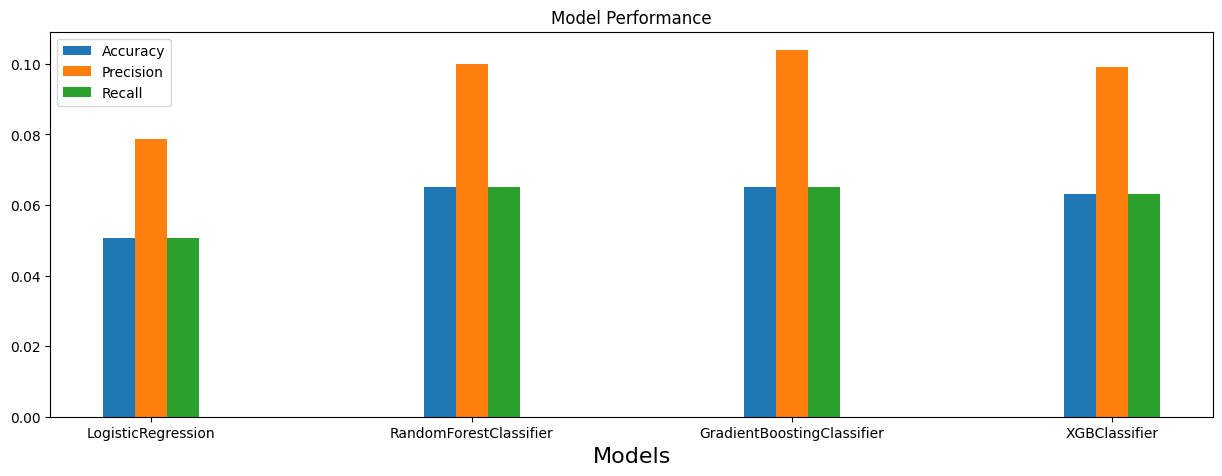

In [226]:
# Plot the results
bar_width = 0.1
acc = np.arange(len(scores["Accuracy"]))
prec = [x + bar_width for x in acc]
rec = [x + bar_width for x in prec]

plt.figure(figsize=(15,5))

plt.bar(acc, scores["Accuracy"], width=bar_width, label='Accuracy')
plt.bar(prec, scores["Precision"], width=bar_width, label='Precision')
plt.bar(rec, scores["Recall"], width=bar_width, label='Recall')

plt.title('Model Performance')
plt.xlabel('Models', fontsize=16)
plt.xticks([i + bar_width for i in range(len(scores["Accuracy"]))], model_names)
plt.legend()

df = pd.DataFrame(scores, index=model_names)